# HW \#3: Policy Gradient: PPO

**Name:**  <font color="red">David Bayha</font>



In this assignment, you are replacing VFA with a policy gradient method, proximal policy optimization.



# I. Overview

Describe the objective of this assignment. You can briefly state how you accompilsh it.

# II. Problem


## Lunar Lander


https://gymnasium.farama.org/environments/box2d/lunar_lander/

![lunar lander](https://gymnasium.farama.org/_images/lunar_lander.gif)




#### STEPS for Lunar Lander

1. [II Problems] First, import gymnasium (if you haven't installed it, make sure install gymnasium first.
1. [II Problems] Initialize, learn and test how the environment works.
1. [II Problems] Explain the environment code.
3. [III Methods] Build your PPO.
4. [III Methods] Explain your RL agent (PPO) with review of PG and PPO and how it is implemented.
5. [IV Results]  Discuss your hyperparameter search process.
5. [IV Results]  Explain your final setup and discuss the agent's performance.




In [49]:
!pip install werkzeug
!pip install swig
!pip install gymnasium[box2d]
# Install necessary dependencies (if not already installed)
!pip install stable-baselines3 torch torchvision torchaudio numpy matplotlib seaborn


In [50]:
!pip uninstall pandas -y
!pip install --no-cache-dir --force-reinstall pandas

Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------- ----- 10.0/11.6 MB 56.4 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 55.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   -------------------------------------- - 12.3/12.9 MB 59.4 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.1
    Uninstalling pytz-2025.1:
      Successfully uninstalled pytz-2025.1
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.1
    Uninstalling tzdata-2025.1:
      Successfully uninstalled tzdata-2025.1
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled s

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.4 which is incompatible.


In [51]:
!pip list | findstr numpy
!pip install --force-reinstall --no-deps numpy==1.26.4

numpy                           2.2.4


  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


In [2]:
!pip install gymnasium[atari] stable-baselines3 ale-py
# Import required libraries
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time
import wrapt
import pandas as pd
!pip install swig
!pip install gym[box2d]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
from torch.distributions import Categorical


The following code block is for the set up and initialization of the LunarLander-v3 environment using the `gymnasium` library to learn what kind of output our model will be receiving. Lunar Lander documentation can be founnd here: https://gymnasium.farama.org/environments/box2d/lunar_lander/

Here's a breakdown of what each line does:
- `np.set_printoptions(suppress=True)`: Configures NumPy to avoid using scientific notation when printing arrays, improving readability of outputs.

- `env = gym.make("LunarLander-v3", render_mode="human")`: Creates the Lunar Lander environment with visual rendering enabled. The v3 version includes improvements in reward structure and termination behavior.

- `state, info = env.reset()`: Resets the environment and returns the initial observation (state) and any additional environment metadata (info).

- `print(...)`: The initial state is printed to understand the environment's starting point.

- `env.action_space`: Returns the set of possible discrete actions the agent can tak in the LunarLander-v3 env (0–3).

- `env.observation_space`: Returns the range and shape of state observations. For LunarLander, this is a continuous space of 8 variables describing the lander's position, velocity, and contact state.


In [4]:
# Suppress scientific notation in numpy for better readability
np.set_printoptions(suppress=True)

# Initialize the Lunar Lander environment
env = gym.make("LunarLander-v3", render_mode="human")

# Reset the environment and observe the initial state
state, info = env.reset()
print("Initial State:", state)

# Define the action space and observation space
print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)

Initial State: [ 0.00228071  1.4134741   0.23100373  0.11350355 -0.00263607 -0.05232578
  0.          0.        ]
Action Space: Discrete(4)
Observation Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


### Environment Interaction Test

Our first environment cell we test the enviroment and step it to ensure it works properly

- `action = env.action_space.sample()`: Randomly selects an action from the action space to ensure the environment responds correctly.

- `next_state, reward, done, truncated, info = env.step(action)`: Applies the selected action and steps the env:
  - `next_state`: The updated observation after the action.
  - `reward`: The immediate reward signal.
  - `done`: Whether the episode has naturally ended.
  - `truncated`: Whether the episode was terminated due to a time limit.
  - `info`: Additional debugging info.

- `env.render()`: Displays the current frame of the environment (has a visible effect if `render_mode='human'` is set).

- `print(...)`: The environment's response to the action is printed to verify proper setup.

- `env.close()`: Closes the rendering window and shuts down the environment cleanly.


In [5]:
# Take a random action to ensure the environment is working
action = env.action_space.sample()
next_state, reward, done, truncated, info = env.step(action)

# Render the environment to visualize the state
env.render()

# Print information about the environment's response
print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)
print("Truncated:", truncated)

# Close the environment after rendering
env.close()


Next State: [ 0.00446806  1.4154576   0.2189761   0.08815789 -0.00287174 -0.00471332
  0.          0.        ]
Reward: 1.8802316721278782
Done: False
Truncated: False


<font color="gray">[Delete Me] add your writing: You can refer to our previous assignment.</font>



# III. Methods

- Describe your PPO model and neural network architecture.
- Describe your approach and the reason why you select it (i.e., explain the network architecture and why you chose it).
- Explain your codes.

ACTOR-CRITIC NEURAL NETWORK SETUP

This part sets up the neural net for the PPO agent — it’s an Actor-Critic network, which just means there are two separate networks: 1)Actor Network which decides what action to take 2) Critic Network which estimates how good a state is (critic). There’s a helper function that builds the agent using the environment’s observation and action space

- `__init__`: This is the constructor of the class
  - `state_dim`: How big the input state is.
  - `action_dim`: # of possible actions the agent can take.
  - `hidden_dim`: The size of the hidden layers, mainly used 64 in mym training runs
  - `dropout`: Dropout rate to help avoid overfitting (0.5 to 0.20).

ACTOR NETWORK (`self.actor_net`):
  - First takes the state as input.
  - Then network runs it through two fully connected layers with LayerNorm, ReLU, and Dropout.
  - Then it shrinks the dimensions down some, applies a Tanh activation, and finishes with one more linear layer.
  - The final output is action logits, which will get turned into probabilities using softmax in the forward pass component.

CRITIC NETWORK (`self.critic_net`):
  - Also takes in the state.
  - Structure is similar to the actor, but the final output is just a single number — the estimated value of that state.

WEIGHT INITIALIZATION (`_init_weights`):
  - Uses orthogonal initialization for the weights (helps with training stability).
  - Biases are initialized to zero.

FORWARD THE ENNVIRONMENT (`forward`):
  - You give it a state, and it gives you back:
    1. A probability distribution over actions (from the actor).
    2. A scalar value estimate for that state (from the critic).

This setup is the backbone of how PPO's Actor and Critic networks make decisions and learn from the environment.


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64, dropout=0.07):
        super(ActorCritic, self).__init__()

        # Actor-specific network
        self.actor_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, action_dim)
        )

        # Critic-specific network
        self.critic_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, state):
        logits = self.actor_net(state)
        value = self.critic_net(state)
        return F.softmax(logits, dim=-1), value

CREATE AGENT AND INITIALIZE NEURAL NETWORK

create_agent(env, hidden_dimensions=64, dropout=0.10)

This function initializes and returns the neural network agent using environment-specific dimensions.

- `env`: The Gym environment used to extract input and output dimensions.
- `hidden_dimensions`: Number of hidden units in each layer of the actor and critic networks.
- `dropout`: Dropout rate applied to the hidden layers for regularization.

INSIDE FUNCTION:
- `input_dim`: Retrieved from `env.observation_space.shape[0]`, defines the number of state features.
- `output_dim`: Retrieved from `env.action_space.n`, defines the number of discrete actions available.
- Then it returns an instance of the `ActorCritic` network initialized with the environment's dimensions and chosen hyperparameters.


In [7]:
def create_agent(env, hidden_dimensions=64, dropout=0.07):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    return ActorCritic(
        state_dim=input_dim,
        action_dim=output_dim,
        hidden_dim=hidden_dimensions,
        dropout=dropout
    )

PROXIMAL POLICY OPTIMIZATION (PPO) CLASS IMPLEMENTATION

This class defines the PPO algorithm, which improves stability during policy updates through clipped surrogate objectives and optional KL divergence penalties.

`__init__` METHOD
- `agent`: The neural network model (actor-critic).
- `learning_rate`: Sets how quickly the model updates its parameters.
- `gamma`: Discount factor for future rewards.
- `epsilon`: Clipping value to control how much the policy is allowed to change.
- `epochs`: Number of passes through the batch of experience per update.
- `lambda_`: GAE smoothing factor, balances bias and variance in advantage estimates.
- `normalize_advantages`: Controls whether to normalize advantages for better convergence.

`compute_gae` METHOD
- Implements Generalized Advantage Estimation (GAE).
- Loops backward over time steps to calculate advantages using temporal differences and exponential weighting.
- Appends the last value with zero to bootstrap at the end.
- Returns both advantage estimates and value-based returns.

`normalize` METHOD
- Standardizes advantage estimates to have zero mean and unit variance, which helps with stable gradient updates.

`update` METHOD - THIS IS THE HEART OF THE MODEL AND WHERE ACTUAL LEARNING TAKES PLACE
- Prepares all training data into mini-batche: All the states, actions, rewards, values, and probabilities collected during an episode are split into smaller batches. This helps keep training stable and efficient, especially when working with large amounts of data.
- Recalculates log probabilities and values for current policy using the agent: For each batch, it passes the states through the current version of the actor-critic networks to get updated action probabilities and value estimates. This is important because the networks may have changed since the data was collected, and PPO compares the "old" policy with the "new" one to control updates.

- WHAT `update` COMPUTES
  - `Clipped surrogate objective`: Instead of just maximizing the difference between the new and old policy (which can cause big jumps), it "clips" the update if it’s too far from the previous policy. This helps avoid unstable learning by keeping changes more gradual.
  - `KL divergence`: KL penalty term to measure how far the new policy has moved from the old one. If the KL difference is too high, it means the policy is changing too fast, so the penalty helps pull it back. This made training much more stable in my runs.
  - `Critic loss`: This part checks how close the critic’s predicted value is to the actual return (what the agent actually got). If the value prediction is off, the critic gets updated to improve its accuracy.
  - `Entropy`: Entropy is used to keep the policy from becoming too confident too soon. If the agent always picks the same action, it might miss better ones. Higher entropy means more exploration, and PPO rewards that a bit to avoid early convergence to a bad strategy.
- Combines these into a `total_loss` which is used to update network weights through backpropagation.


Initially, the model struggled to consistently learn. While it occasionally reached rewards above 100, it plateaued early and failed to break past 120. The learning curve was very small, rewards were exteremly volatile, and episodes often ended prematurely. But when I added in a KL divergence penalty between the old and new policies it significantly stabilized training. It all of a sudden began to achieve 200+ rewards (threshold for successful episode) frequently throughout training. What L divergences does is it discourages the updated policy from drifting too far from the previous one, which in turn allows the agent to avoid catastrophic policy collapses. This was the pivotal component to be added and allowed me to expand my hyper parameter search with confidence in the ppo architecture's ability to adapt.

I added some plots at the end to track the kl divergence, entropy and various loss components' performance throughout the latest run.


In [8]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
from torch.distributions import Categorical

class PPO:
    def __init__(self, agent, learning_rate=4e-4, gamma=0.99, epsilon=0.17, epochs=5, lambda_=0.96, normalize_adv=True):
        self.agent = agent
        self.optimizer = torch.optim.Adam(self.agent.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epochs = epochs
        self.lambda_ = lambda_
        self.normalize_advantages = normalize_adv

        # Metric tracking
        self.kl_history = []
        self.entropy_history = []
        self.critic_loss_history = []
        self.actor_loss_history = []
        self.total_loss_history = []
        self.episode_rewards = []

    def compute_gae(self, rewards, values, dones, lambda_=0.96):
        advantages = []
        gae = 0

        if torch.is_tensor(values):
            values = values.detach().numpy()

        T = len(rewards)
        values_extended = np.append(values, [0.0])

        for i in reversed(range(T)):
            delta = rewards[i] + self.gamma * values_extended[i+1] * (1 - dones[i]) - values_extended[i]
            gae = delta + self.gamma * lambda_ * (1 - dones[i]) * gae
            advantages.insert(0, gae)

        advantages = torch.tensor(advantages, dtype=torch.float32)
        returns = advantages + torch.tensor(values[:len(advantages)], dtype=torch.float32)
        return advantages, returns

    def normalize(self, x):
        if self.normalize_advantages:
            return (x - x.mean()) / torch.clamp(x.std(), min=1e-4)
        return x

    def update(self, states, actions, old_probs, rewards, dones, values):
        advantages, returns = self.compute_gae(rewards, values.detach().numpy(), dones, lambda_=self.lambda_)
        advantages = self.normalize(advantages)

        states = states.float()
        actions = actions.float()
        old_probs = old_probs.float()
        advantages = advantages.float()
        returns = returns.float()

        BATCH_SIZE = 64

        avg_kl = 0
        avg_entropy = 0
        avg_critic_loss = 0
        avg_actor_loss = 0
        avg_total_loss = 0
        num_batches = 0

        for _ in range(self.epochs):
            num_batches = max(1, len(states) // BATCH_SIZE)
            for i in range(num_batches):
                start = i * BATCH_SIZE
                end = start + BATCH_SIZE

                batch_states = states[start:end]
                batch_actions = actions[start:end]
                batch_old_probs = old_probs[start:end]
                batch_advantages = advantages[start:end]
                batch_returns = returns[start:end]

                action_probs, current_values = self.agent(batch_states)
                dist = Categorical(action_probs)
                current_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean()

                with torch.no_grad():
                    old_dist = Categorical(probs=batch_old_probs)
                    old_log_probs = old_dist.log_prob(batch_actions)

                kl_div = torch.distributions.kl.kl_divergence(old_dist, dist).mean()
                kl_penalty = 0.5 * kl_div

                ratios = torch.exp(current_probs - old_log_probs)
                surr1 = ratios * batch_advantages
                surr2 = torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * batch_advantages

                actor_loss = -torch.min(surr1, surr2).mean()
                value_pred_clipped = current_values.squeeze(-1) + torch.clamp(
                    current_values.squeeze(-1) - batch_returns, -0.2, 0.2
                )
                critic_loss = 0.5 * torch.max(
                    F.mse_loss(current_values.squeeze(-1), batch_returns),
                    F.mse_loss(value_pred_clipped, batch_returns)
                )
                entropy_loss = -0.005 * entropy
                total_loss = actor_loss + 0.5 * critic_loss + entropy_loss + kl_penalty

                self.optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.agent.parameters(), 0.2)
                self.optimizer.step()

                avg_kl += kl_div.item()
                avg_entropy += entropy.item()
                avg_critic_loss += critic_loss.item()
                avg_actor_loss += actor_loss.item()
                avg_total_loss += total_loss.item()

        self.kl_history.append(avg_kl / (self.epochs * num_batches))
        self.entropy_history.append(avg_entropy / (self.epochs * num_batches))
        self.critic_loss_history.append(avg_critic_loss / (self.epochs * num_batches))
        self.actor_loss_history.append(avg_actor_loss / (self.epochs * num_batches))
        self.total_loss_history.append(avg_total_loss / (self.epochs * num_batches))
    
    def record_reward(self, reward):
        self.episode_rewards.append(reward)

    def plot_metrics(self):
        plt.figure(figsize=(15, 10))

        plt.subplot(3, 2, 1)
        plt.plot(self.kl_history)
        plt.title("KL Divergence")

        plt.subplot(3, 2, 2)
        plt.plot(self.entropy_history)
        plt.title("Entropy")

        plt.subplot(3, 2, 3)
        plt.plot(self.critic_loss_history)
        plt.title("Critic Loss")

        plt.subplot(3, 2, 4)
        plt.plot(self.actor_loss_history)
        plt.title("Actor Loss")

        plt.subplot(3, 2, 5)
        plt.plot(self.total_loss_history)
        plt.title("Total Loss")

        plt.subplot(3, 2, 6)
        plt.plot(self.episode_rewards)
        plt.title("Episode Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Reward")

        plt.tight_layout()
        plt.show()



TRAINING LOOP

This function controls the interaction between the agent and the environment over many episodes.

MAIN COMPONENTS
- Initializes episode variables like states, actions, rewards, and log probabilities.
- For each step in the episode:
  - Passes the current state to the agent.
  - Samples an action using the categorical distribution.
  - Stores all necessary data for PPO training: state, action, action probabilities, and value.
  - Steps the environment and checks if the episode is done.

POST EPISODE COMPONENTS
- Converts all collected data into PyTorch tensors.
- Calls the `ppo.update()` function to improve the policy and value function using the stored experience.
- Saves the model if the reward is the best seen so far.
- Logs performance after each episode.

This loop continues for the number of episodes set, I typically did 1500 after getting a successful model with 3000.


In [9]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def train(env, agent, ppo, num_episodes, render=False, seed=42):
    best_reward = float('-inf')
    
    for episode in range(num_episodes):
        state, _ = env.reset()  
        done = False
        episode_reward = 0
        
        states, actions, rewards, dones = [], [], [], []
        old_probs, values = [], []

        while not done:
            if render:
                env.render()

            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs, value = agent(state_tensor)
            action_probs = torch.clamp(action_probs, 1e-6, 1.0)  # <- clamp after assignment
            dist = Categorical(action_probs)

            action = dist.sample()
            
            states.append(state)
            actions.append(action)
            old_probs.append(action_probs.squeeze(0).detach())  # store full probs

            values.append(value.item())

            # Updated to handle new Gym API with terminated and truncated flags.
            state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            rewards.append(reward)
            dones.append(done)
            episode_reward += reward

        # Convert lists to tensors for update.
        states = torch.FloatTensor(states)
        actions = torch.tensor(actions)
        old_probs = torch.stack(old_probs).detach()
        values = torch.FloatTensor(values)

        ppo.update(states, actions, old_probs, rewards, dones, values)

        if episode_reward > best_reward:
            best_reward = episode_reward
            torch.save(agent.state_dict(), 'main_ppo_model.pth')

        print(f"Episode {episode}, Reward: {episode_reward:.2f}, Best: {best_reward:.2f}")
        ppo.record_reward(episode_reward)


In [ ]:
def test(env, agent, num_episodes=10, render=False):
    agent.eval()  # Set model to evaluation mode
    total_rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            if render:
                env.render()

            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_probs, _ = agent(state_tensor)
                action_probs = torch.clamp(action_probs, 1e-6, 1.0)  # ensure stability
                dist = Categorical(action_probs)
                action = dist.sample().item()

            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        total_rewards.append(episode_reward)
        print(f"Test Episode {episode + 1}: Reward = {episode_reward:.2f}")

    avg_reward = sum(total_rewards) / num_episodes
    print(f"\nAverage Reward over {num_episodes} test episodes: {avg_reward:.2f}")

MAIN FUNCTION THAT IMPLEMENTS TRAINING

CREATE ENVIRONMENT:
   - `env = gym.make('LunarLander-v3', render_mode="rgb_array")`
   - Initializes the LunarLander environment using Gymnasium with visual rendering enabled (optional for debugging).

INITIALIZE AGENT:
   - `agent = create_agent(env=env, hidden_dimensions=64, dropout=0.10)`
   - Calls `create_agent()` to generate the neural network using the environment's specifications.

APPLY CREATE PPO MODEL ARCHITECTURE:
   - `ppo = PPO(agent)`
   - Initializes the PPO class with the neural network agent and default hyperparameters.

TRAINING OF THE AGENT:
   - `train(env, agent, ppo, num_episodes=1500)`
   - Begins training the agent using Proximal Policy Optimization for 1500 episodes.

ENTRY POINT DOUBLE-CHECK:
   - `if __name__ == "__main__":`
   - Ensures that training only runs when the script is executed directly, not when imported as a module.


In [11]:
def mainTrain():
    set_seed(42)
    # Create the LunarLander environment with rendering mode set.
    env = gym.make('LunarLander-v3', render_mode=None)
    env.action_space.seed(42)
    env.observation_space.seed(42)
    agent = create_agent(env=env, hidden_dimensions=64, dropout=0.07)
    ppo = PPO(agent)
    train(env, agent, ppo, num_episodes=1500, seed=42)
    ppo.plot_metrics()
if __name__ == "__main__":
    mainTrain()


C:\Users\David\AppData\Local\Temp\ipykernel_40336\2858432120.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.FloatTensor(states)


Episode 0, Reward: -100.39, Best: -100.39
Episode 1, Reward: -94.59, Best: -94.59
Episode 2, Reward: -132.45, Best: -94.59
Episode 3, Reward: -479.20, Best: -94.59
Episode 4, Reward: -324.48, Best: -94.59
Episode 5, Reward: -450.88, Best: -94.59
Episode 6, Reward: -312.58, Best: -94.59
Episode 7, Reward: -126.63, Best: -94.59
Episode 8, Reward: -101.83, Best: -94.59
Episode 9, Reward: -167.13, Best: -94.59
Episode 10, Reward: -270.18, Best: -94.59
Episode 11, Reward: -242.51, Best: -94.59
Episode 12, Reward: -289.03, Best: -94.59
Episode 13, Reward: -204.64, Best: -94.59
Episode 14, Reward: -326.75, Best: -94.59
Episode 15, Reward: -335.02, Best: -94.59
Episode 16, Reward: -107.66, Best: -94.59
Episode 17, Reward: -317.01, Best: -94.59
Episode 18, Reward: -130.62, Best: -94.59
Episode 19, Reward: -114.59, Best: -94.59
Episode 20, Reward: -121.80, Best: -94.59
Episode 21, Reward: -133.89, Best: -94.59
Episode 22, Reward: -96.34, Best: -94.59
Episode 23, Reward: -111.16, Best: -94.59
Epi

KeyboardInterrupt: 

TEST LOOP IMPLEMENTATION

This current setup has been my most successful hyper parameter thus far in testing.  I was surprised to see it start strong and then diminish in performance, but it is clear the agent is learning and further hyper parameter adjustments will be explored in the next assignment with experience replay + deeper exploration.

CURRENT TEST MODEL'S HYPER PARAMETER CONFIGURATION
kl_penalty = 0.4, learning_rate=4e-4, gamma=0.99, epsilon=0.17, epochs=5, lambda_=0.96, entropy_loss = -0.005, clipping=0.2,dropout=0.07, batch_size=64, hidden_dimensions=64

MAIN FUNCTION THAT IMPLEMENTS TESTING

CREATE ENVIRONMENT:

 - `env = gym.make('LunarLander-v3', render_mode=None)`
    - Initializes the LunarLander environment using Gymnasium with visual rendering disabled (can be set to "human" for visual debugging).

SET SEEDS FOR REPRODUCIBILITY:
- `env.action_space.seed(42)`
`env.observation_space.seed(42)`
`torch.manual_seed(42)`
    - This part ensures deterministic behavior by setting seeds for action space, observation space, and PyTorch.

INITIALIZE AGENT:

`agent = create_agent(env=env, hidden_dimensions=64, dropout=0.07)`
    - Calls create_agent() to rebuild the same neural network architecture used during training, using the environment's input/output dimensions.

LOAD TRAINED MODEL WEIGHTS:
- `agent.load_state_dict(torch.load('second_ppo_model.pth'))`
    - Loads the saved policy network weights into the agent to restore its trained behavior.

TESTING OF THE AGENT:
- `test(env, agent, num_episodes=30, render=False)`
    -Runs the agent for 30 episodes in test mode without rendering. Outputs rewards and helps evaluate agent performance after training.

ENTRY POINT DOUBLE-CHECK:
- `if __name__ == "__main__":`
    - Ensures the test runs only when the script is executed directly, preventing automatic execution during import.


In [14]:
def mainTest():
    # Create the LunarLander environment
    env = gym.make('LunarLander-v3', render_mode='human')

    # Set seeds for reproducibility
    env.action_space.seed(42)
    env.observation_space.seed(42)
    torch.manual_seed(42)

    # Recreate the agent architecture
    agent = create_agent(env=env, hidden_dimensions=64, dropout=0.15)

    # Load the trained model weights
    agent.load_state_dict(torch.load('main_ppo_model.pth'))
    
    # Run the test
    test(env, agent, num_episodes=60, render=False)
if __name__ == "__main__":
    mainTest()


Test Episode 1: Reward = -111.54
Test Episode 2: Reward = -184.95
Test Episode 3: Reward = -171.45
Test Episode 4: Reward = -94.05
Test Episode 5: Reward = -132.18
Test Episode 6: Reward = -157.89
Test Episode 7: Reward = -144.35
Test Episode 8: Reward = -171.94
Test Episode 9: Reward = -119.20
Test Episode 10: Reward = -71.12
Test Episode 11: Reward = -193.52


KeyboardInterrupt: 

# IV - Results

- Describe the choice of your hyper-parameters.
  - Run "**thorough**" experiments to find good hyper-parameters (Need all results to be presented)
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.
    - Hint: example visualization can be the reward/return curve, win/lose plot, score plot, etc.
    -       Feel free to try new plots if you want.

ANALYSIS OF TRAINING METRICS:
For the kl divergence plot it starts off a bit high, which is normal when the policy is changing quickly at the beginning. The it drops down and levels out around 0.01 for most of training, with a few spikes (spikes mean the policy updates were mostly stable but occasionally had bigger updates than usual). For entropy it gradually decreases over time since at first the agent is exploring a lot (new uncertain environment), but as it learns what actions work, it becomes more confident and focuses in on the optimal policy (lower entropy). The small bumps later on suggest the agent still tries new things occasionally, which can be good to avoid getting stuck at a local minima. For critic loss the model starts really high and drops off quickly, which shows the value function is learning fast. It gets more stable after the first 300–400 episodes, but it has a big spike during episodes after 1000, which I thought was very interesting.  The later episodes in the training run seemm to have higher loss, maybe there is a certain number of episodes that work best? For actor loss it is very volatile, which conceptually makes sense because the actor is the one who is taking the initial actions and then later gets evaluated by the critic network to gradually improve action probabilities in their given states. For total loss it looks similar to the critic loss plot which shows how the critic network corrects the actor's loss to improve the policy for the PPO agent.


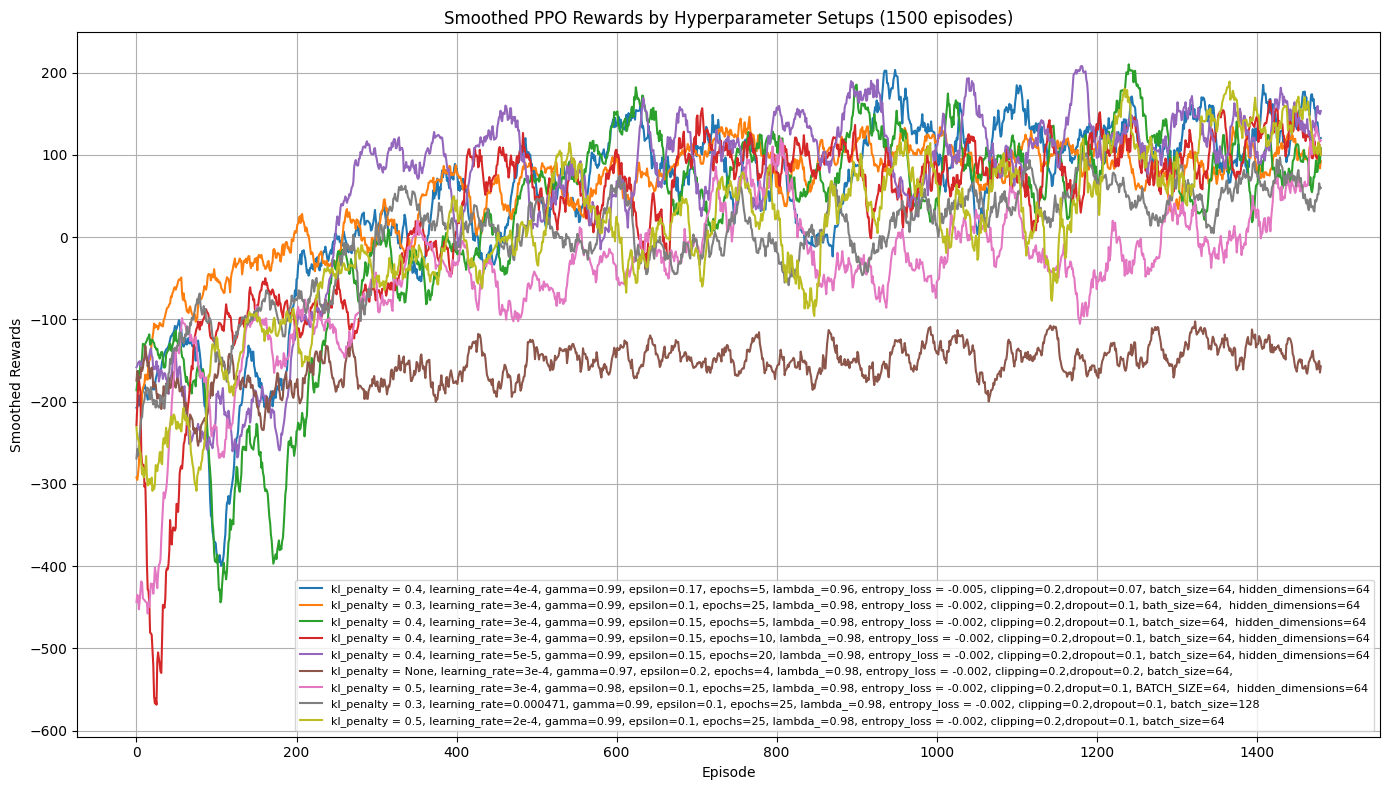

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re

# Set your reward file directory
directory = r"C:/Users/David/OneDrive/Desktop/DSBA 6010 DRL"

# Moving average smoothing function
def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Load reward data from a log-style file
def load_rewards(filepath, max_episodes=1500):
    rewards = []
    try:
        with open(filepath, 'r') as file:
            for line in file:
                # Match lines like: Episode 0, Reward: -270.43, Best: -270.43
                match = re.search(r"Reward:\s*(-?\d+\.?\d*)", line)
                if match:
                    rewards.append(float(match.group(1)))
                if len(rewards) >= max_episodes:
                    break
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
    return rewards

# Grab hyperparameter label from first line of file
def get_hyperparam_label(filepath):
    try:
        with open(filepath, 'r') as file:
            return file.readline().strip()
    except Exception as e:
        print(f"Could not read hyperparameters from {filepath}: {e}")
        return os.path.basename(filepath)

# List your filenames to include
filenames = [
    "best.txt", "kl_2.txt", "kl3.txt", "kl4.txt", "kl5.txt",
    "before_kl_1.txt", "droput_1.txt", "batchsze_1.txt", "lr2e4.txt"
]

# Start the plot
plt.figure(figsize=(14, 8))

for filename in filenames:
    path = os.path.join(directory, filename)
    rewards = load_rewards(path)
    label = get_hyperparam_label(path)

    if rewards:
        smoothed = moving_average(rewards)
        plt.plot(smoothed, label=label)
    else:
        print(f" Skipping {filename}: no usable reward data.")

# Customize plot
plt.title("Smoothed PPO Rewards by Hyperparameter Setups (1500 episodes)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Rewards")
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

BEST TRAINING RUN: 
    BLUE LINE: kl_penalty = 0.4, learning_rate=4e-4, gamma=0.99, epsilon=0.17, epochs=5, lambda_=0.96, entropy_loss = -0.005, clipping=0.2,dropout=0.07, batch_size=64, hidden_dimensions=64

HYPER PARAMETER ANALYSIS
After running a wide range of hyperparameter configurations for PPO on the LunarLander-v3 environment, I observed some clear patterns in how these design choices influenced learning stability, speed, and final performance. The cumulative reward plots below reflect all of these variations and were smoothed using a moving average for better visibility of general trends.

KL DIVERGENCE = KEY COMPONENT IN MY MODEL
The biggest turning point in performance came from introducing a KL divergence penalty into the PPO update step. Before this, the agent consistently plateaued around +120 reward and struggled to maintain stability — it would fluctuate heavily and never push into consistently successful landings. However, once I added the KL component, the best runs immediately jumped toward +200 reward, with the top performer peaking just over 300. This change helped regulate how far the policy could deviate between updates, likely keeping training on a more stable trajectory. Before KL, the policy may have been over-updating and failing to retain prior knowledge between episodes.

LEARNING RATE
Learning rate had a noticeable effect as well. I tried both 3e-4 and 5e-4 in different runs. Interestingly, the best-performing run used the higher learning rate (5e-4), paired with 20 training epochs and a relatively moderate KL penalty. The result was fast early learning and a strong final reward. That said, many other high-performing runs also used 3e-4 with only minor tradeoffs in learning speed. So while 5e-4 gave better momentum in this case, 3e-4 seemed more broadly stable across other configs. One interesting note was that extremely low learning rates like 2e-4 with no compensating batch size increase led to flat or unstable learning — it seemed like the updates were just too small to make real progress.

EPSILON
Epsilon was another major factor. I found that higher values (like 0.15 or 0.2) allowed more aggressive updates, which helped the policy escape local optima early on. For example, the orange and green runs both used epsilon=0.15, and both reached high reward levels quickly, albeit with some extra volatility. When epsilon was lowered to 0.1, the training was more stable but sometimes too conservative — particularly when not combined with higher learning rates or stronger KL penalties. This supports the idea that PPO benefits from tuning the balance between cautious policy shifts and enough freedom to explore new strategies.

EPOCHS
Epoch count affected how fast the agent learned but also interacted with the other hyperparameters in subtle ways. Shorter epoch runs (like 5 or 10) learned quickly if paired with higher epsilon and KL, but those same values underperformed when the training duration was too short or when dropout was too high. For example, one run with just 4 epochs and a dropout of 0.2 basically flatlined near -100 the entire time. On the flip side, increasing epochs up to 25 led to more stability in some of the mid-performing runs, even if they didn’t reach the same peak.

DROPOUT
Dropout was another key parameter that I found worked better with lower values. I settled on 0.1 as a sweet spot — it regularized the networks enough to avoid overfitting, but didn’t overly suppress learning capacity. When I tried 0.15 or 0.2, especially with low epochs or learning rates, performance tanked. Dropout seems to matter more when training isn’t long or aggressive enough to overcome it. So my takeaway is that dropout only helps when paired with enough training signal and update capacity to balance it out.

Batch size was something I tested too. Most runs used 64, but I tried a 128 batch version as well. That model started off slow, probably because of delayed gradient updates from larger sampling, but eventually climbed into decent reward territory. So while bigger batches helped reduce noise, they likely made early exploration harder unless paired with higher learning rates.

Finally, gamma and lambda were kept consistent across runs (0.99 and 0.98), and that seemed to work well. I did try one experiment with gamma=0.97, and it clearly underperformed — slower learning, worse credit assignment, and more instability. I’ll definitely keep these values fixed in the future.

CONCLUSION
Overall, the best performance came from models that used a KL penalty around 0.4, learning rates of 3e-4 or 5e-4, epsilon between 0.1 and 0.15, around 10–20 epochs, and dropout of 0.1. These agents showed both fast learning and stable convergence. In contrast, low learning rates, high dropout, and short training durations created noisy or flat training runs. This assignment helped me see how even small hyperparameter shifts can totally change how the PPO algorithm behaves — from failing to land at all to scoring 200+ consistently. I also now better understand how PPO’s policy constraints like KL divergence and entropy interact with learning speed and variance. It was really satisfying to finally get models that could land the Lunar Lander reliably after so many runs that just bounced around or crashed.

TOP THREE RUNS HIGHLIGHTED IN PLOT BELOW

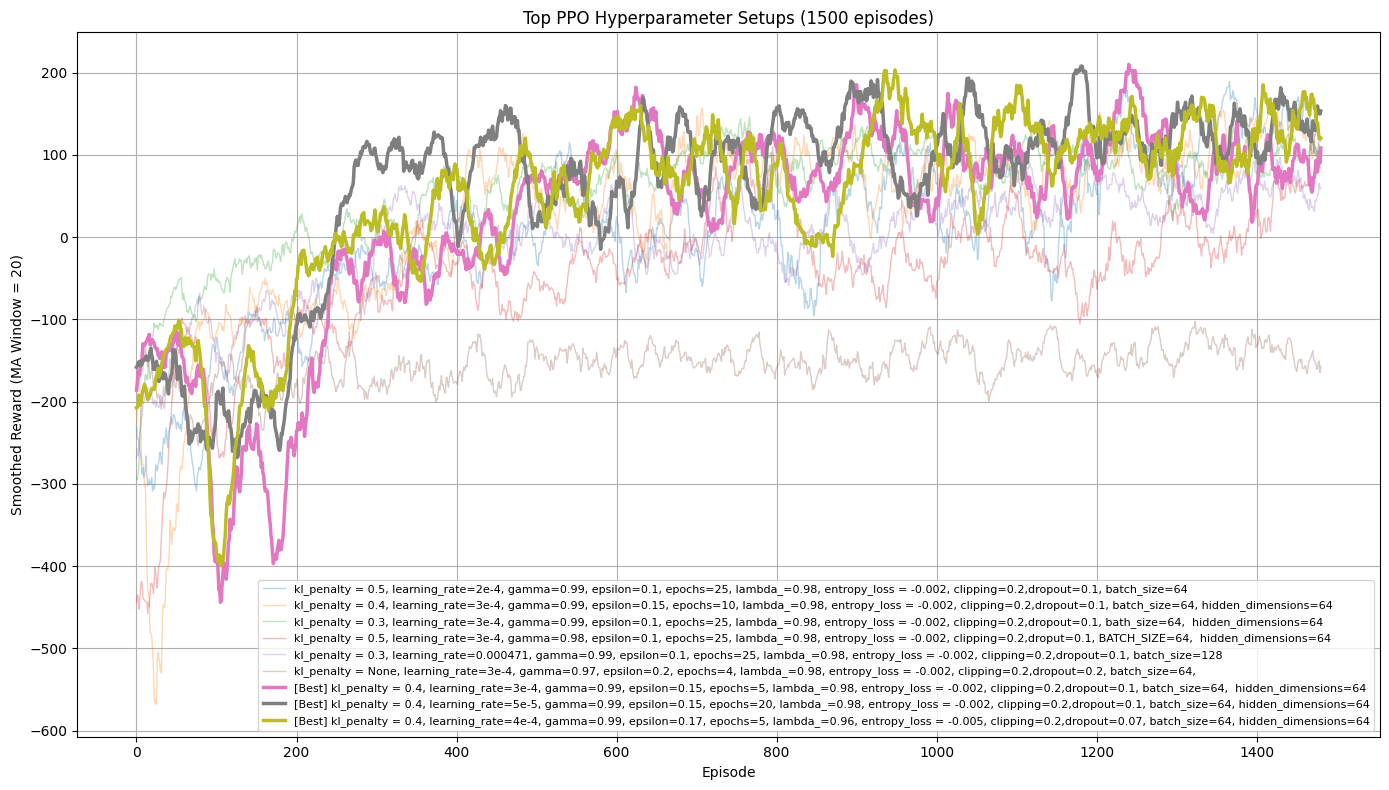

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re

directory = r"C:/Users/David/OneDrive/Desktop/DSBA 6010 DRL"

def moving_average(data, window_size=20):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def load_rewards(filepath, max_episodes=1500):
    rewards = []
    try:
        with open(filepath, 'r') as file:
            for line in file:
                match = re.search(r"Reward:\s*(-?\d+\.?\d*)", line)
                if match:
                    rewards.append(float(match.group(1)))
                if len(rewards) >= max_episodes:
                    break
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
    return rewards

def get_hyperparam_label(filepath):
    try:
        with open(filepath, 'r') as file:
            return file.readline().strip()
    except Exception:
        return os.path.basename(filepath)

# List of files to analyze
filenames = [
    "best.txt", "kl_2.txt", "kl3.txt", "kl4.txt", "kl5.txt",
    "before_kl_1.txt", "droput_1.txt", "batchsze_1.txt", "lr2e4.txt"
]

reward_data = []

# First, load and store all results
for fname in filenames:
    path = os.path.join(directory, fname)
    rewards = load_rewards(path)
    if rewards:
        smoothed = moving_average(rewards)
        label = get_hyperparam_label(path)
        max_reward = np.max(smoothed)
        reward_data.append((smoothed, label, max_reward))
    else:
        print(f"⚠ Skipping {fname}: no usable reward data.")

# Sort by best reward achieved and choose top N
reward_data.sort(key=lambda x: x[2], reverse=True)
top_n = 3
top_runs = reward_data[:top_n]
rest_runs = reward_data[top_n:]

# Plot
plt.figure(figsize=(14, 8))

# Plot faded lines for non-top runs
for smoothed, label, _ in rest_runs:
    plt.plot(smoothed, label=label, alpha=0.3, linewidth=1)

# Plot bold lines for top runs
for smoothed, label, _ in top_runs:
    plt.plot(smoothed, label=f"[Best] {label}", linewidth=2.5)

# Labels and title
plt.title("Top PPO Hyperparameter Setups (1500 episodes)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward (MA Window = 20)")
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

BEST PERFORMING HYPER PARAMETER CONFIGURATIONS:
PINK LINE: kl_penalty =0.4, learning_rate=3e-4, gamma=0.99, epsilon=0.15, epochs=5, lambda _= 0.98, entropy_loss = -0.002, clipping=0.2,dropout=0.1, batch_size=64, hidden_dimensions=64
GREY LINE: kl_penalty =0.4, learning_rate=5e-5, gamma=0.99, epsilon=0.15, epochs=20, lambda _= 0.98, entropy_loss =- 0.002, clipping=0.2,dropout=0.1, batch_size=64, hidden_dimensions=64
OLIVE GREEN: kl_penalty = 0.4, learning_rate=4e-4, gamma=0.99, epsilon=0.17, epochs=5, lambda _= 0.96, entropy_loss = -0.005, clipping=0.2,dropout=0.07, batch_size=64, hidden_dimensions=64

# V. Conclusions

Discuss the challenges or somethat that you learned.
If you have any suggestion about the assignment, you can write about it.

# Extra Credit (maximum 4 possible credits)

## Car Racing

https://gymnasium.farama.org/environments/box2d/car_racing/

![car racing](https://gymnasium.farama.org/_images/car_racing.gif)

[Option 1] Solve Car Racing with PPO + other tricks reaching average training reward over 900. (1 extra credit)

[Option 2] Class rank from the EC solutions.  
  - Rank 1 (3 extra credit points)
  - Rank 2 (2 extra credit points)
  - Rank 3 & 4 (1 extra credit point)

<font color="red">To be qualified for extra credit, you should complete the work (no partial point).</font>


# Submission

You are required to submit three files.
1. This notebook with complete writing.
2. Stored keras or pytorch model(s) (if you complete the extra credit assignment, you should submit an additional model file for car racing)
3. Another notebook that load the model and test the trained model on the lunar lander and car racing (in case you work for EC only) environment.

## Grading

For this assignment, the grading rubric is a bit different. Please check it carefully.


points | | description
--|--|:--
5 | Overview| states the objective and the appraoch
20 | Problem |
 |10| Code for setting up the environment
 | 5| Explanation of Lunar Lander problem
 | 5| explanation of the codes to use Lunar Lander from Gymnasium
25 | Methods |
 |15| Your PPO agent codes
 |10| Explanation of your implementation and PPO method
35 | Results
 |15| Combinations of different hyperparameters (Hyperparameter search)
 |5| Experimental outputs that show the choice of parameters. Explanation of how do you choose them?
 |5| Visualization of learning and learned agent
 |10| Observations and analysis of learning results and plots
5 | Conclusions
10 | Successful test of the submitted model